In [ ]:
!pip install prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpvagdkdi_/y_5r8r6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvagdkdi_/mie9yowl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64993', 'data', 'file=/tmp/tmpvagdkdi_/y_5r8r6_.json', 'init=/tmp/tmpvagdkdi_/mie9yowl.json', 'output', 'file=/tmp/tmpvagdkdi_/prophet_modelazmf3o7p/prophet_model-20250711155953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:59:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:59:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📊 R² score on last 6 months: 0.8944
📉 RMSE on last 6 months: ₹750.95


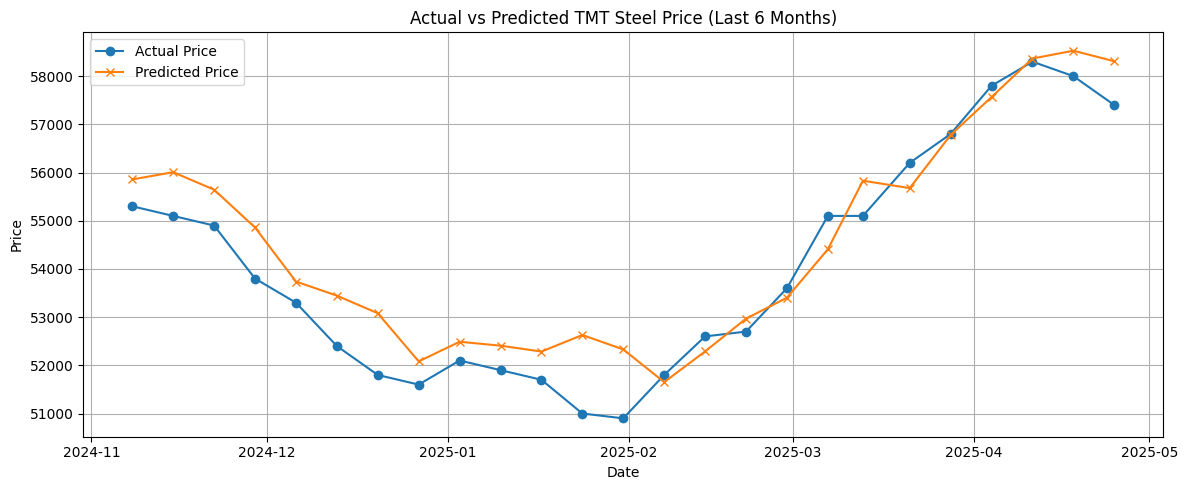

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

# Load and clean the dataset
df = pd.read_csv("/content/MERGED_BF_CLEAN_DATA(1).csv")
columns_to_drop = [
    'Iron_Ore_Chattisgarh_Price', 'Iron_Ore_Bolani_Price',
    'Scrap_Durgapur_Price', 'Coal_Price',
    'Ingot_Price', 'Thermal_Coal_Price'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Feature engineering
df['Lag1'] = df['BF_Price'].shift(1)
df['Lag2'] = df['BF_Price'].shift(2)
df['Rolling7'] = df['BF_Price'].rolling(window=7).mean()
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['is_monsoon'] = df['Date'].dt.month.between(6, 9).astype(bool)
df.dropna(inplace=True)

# Define features
features = ['Scrap_Mandi_Price', 'Sponge_Iron_DRCLO_Price', 'Sponge_Iron_PDRI_Price',
            'Lag1', 'Lag2', 'Rolling7', 'Month', 'Weekday', 'is_monsoon']

# Prepare Prophet-compatible DataFrame
prophet_df = df[['Date', 'BF_Price'] + features].rename(columns={'Date': 'ds', 'BF_Price': 'y'})

# Split into train and test (last 6 months for test)
split_date = df['Date'].max() - pd.DateOffset(months=6)
train_df = prophet_df[prophet_df['ds'] <= split_date].copy()
test_df = prophet_df[prophet_df['ds'] > split_date].copy()

# Build Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Add custom seasonality
model.add_seasonality(
    name='monsoon_season',
    period=365.25,
    fourier_order=10,
    condition_name='is_monsoon'
)

# Add regressors except for the seasonal condition variable
regressor_features = [f for f in features if f != 'is_monsoon']
for reg in regressor_features:
    model.add_regressor(reg)

# Fit model on training data
model.fit(train_df)

# Prepare full dataframe (for prediction over both train and test)
future_all = prophet_df[['ds']].copy()
future_all['is_monsoon'] = future_all['ds'].dt.month.between(6, 9).astype(bool)

# Add regressors for historical dates
for reg in regressor_features:
    future_all[reg] = prophet_df[reg].values

# Predict on entire set (to extract test forecast for R² and RMSE)
full_forecast = model.predict(future_all)

# Merge predictions with test_df to calculate R² and RMSE
merged = test_df.merge(full_forecast[['ds', 'yhat']], on='ds', how='left')
r2 = r2_score(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

# ✅ Save predicted vs actual values to CSV
merged.rename(columns={'yhat': 'predicted'}, inplace=True)
merged.to_csv("LAST6MONTHS_WITHLAGFEATURES_AND_CORRELATED_VARIABLES_BF.csv", index=False)


print(f"\n📊 R² score on last 6 months: {r2:.4f}")
print(f"📉 RMSE on last 6 months: ₹{rmse:.2f}")

# Plot actual vs predicted for last 6 months
plt.figure(figsize=(12, 5))
plt.plot(merged['ds'], merged['y'], label='Actual Price', marker='o')
plt.plot(merged['ds'], merged['predicted'], label='Predicted Price', marker='x')
plt.title("Actual vs Predicted TMT Steel Price (Last 6 Months)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



DEBUG:cmdstanpy:input tempfile: /tmp/tmpvagdkdi_/b8j82jyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvagdkdi_/vot87e60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45527', 'data', 'file=/tmp/tmpvagdkdi_/b8j82jyy.json', 'init=/tmp/tmpvagdkdi_/vot87e60.json', 'output', 'file=/tmp/tmpvagdkdi_/prophet_modeljmbp5e21/prophet_model-20250711160012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📊 R² score on last 6 months: 0.9593
📉 RMSE on last 6 months: ₹297.67


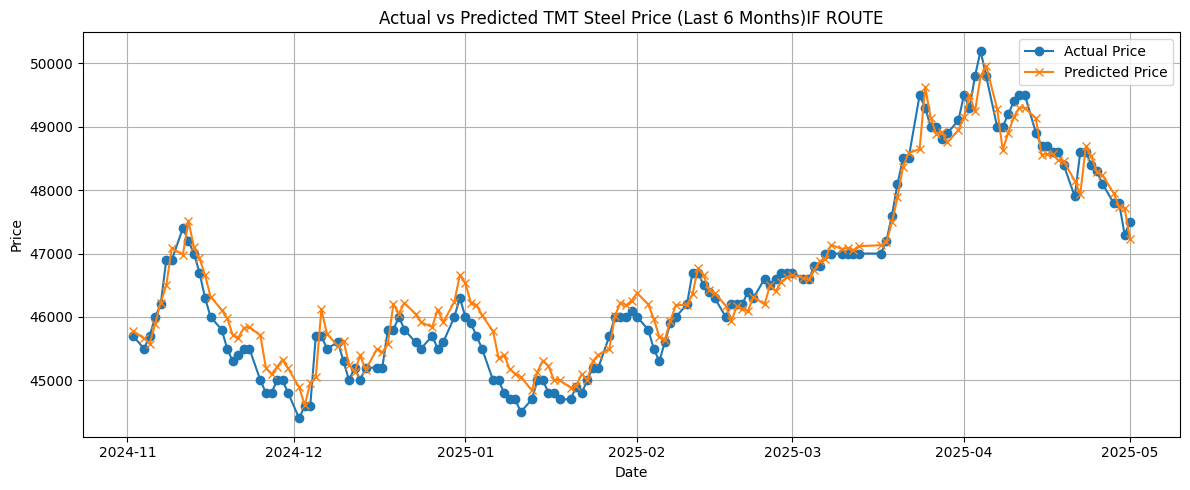

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

# Load and clean the dataset
df = pd.read_csv("/content/MERGED_IF_CLEAN_DATA(1).csv")
columns_to_drop = [
    'Iron_Ore_Chattisgarh_Price', 'Iron_Ore_Bolani_Price',
    'Scrap_Durgapur_Price', 'Coal_Price',
    'Ingot_Price', 'Thermal_Coal_Price'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Feature engineering
df['Lag1'] = df['IF_Price'].shift(1)
df['Lag2'] = df['IF_Price'].shift(2)
df['Rolling7'] = df['IF_Price'].rolling(window=7).mean()
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['is_monsoon'] = df['Date'].dt.month.between(6, 9).astype(bool)
df.dropna(inplace=True)

# Define features
features = ['Scrap_Mandi_Price', 'Sponge_Iron_DRCLO_Price', 'Sponge_Iron_PDRI_Price',
            'Lag1', 'Lag2', 'Rolling7', 'Month', 'Weekday', 'is_monsoon']

# Prepare Prophet-compatible DataFrame
prophet_df = df[['Date', 'IF_Price'] + features].rename(columns={'Date': 'ds', 'IF_Price': 'y'})

# Split into train and test (last 6 months for test)
split_date = df['Date'].max() - pd.DateOffset(months=6)
train_df = prophet_df[prophet_df['ds'] <= split_date].copy()
test_df = prophet_df[prophet_df['ds'] > split_date].copy()

# Build Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)

# Add custom seasonality
model.add_seasonality(
    name='monsoon_season',
    period=365.25,
    fourier_order=10,
    condition_name='is_monsoon'
)

# Add regressors except for the seasonal condition variable
regressor_features = [f for f in features if f != 'is_monsoon']
for reg in regressor_features:
    model.add_regressor(reg)

# Fit model on training data
model.fit(train_df)

# Prepare full dataframe (for prediction over both train and test)
future_all = prophet_df[['ds']].copy()
future_all['is_monsoon'] = future_all['ds'].dt.month.between(6, 9).astype(bool)

# Add regressors for historical dates
for reg in regressor_features:
    future_all[reg] = prophet_df[reg].values

# Predict on entire set (to extract test forecast for R² and RMSE)
full_forecast = model.predict(future_all)

# Merge predictions with test_df to calculate R² and RMSE
merged = test_df.merge(full_forecast[['ds', 'yhat']], on='ds', how='left')
r2 = r2_score(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
# ✅ Save predicted vs actual values to CSV
merged.rename(columns={'yhat': 'predicted'}, inplace=True)
merged.to_csv("LAST6MONTHS_WITHLAGFEATURES_AND_CORRELATED_VARIABLES_IF.csv", index=False)

print(f"\n📊 R² score on last 6 months: {r2:.4f}")
print(f"📉 RMSE on last 6 months: ₹{rmse:.2f}")

# Plot actual vs predicted for last 6 months
plt.figure(figsize=(12, 5))
plt.plot(merged['ds'], merged['y'], label='Actual Price', marker='o')
plt.plot(merged['ds'], merged['predicted'], label='Predicted Price', marker='x')
plt.title("Actual vs Predicted TMT Steel Price (Last 6 Months)IF ROUTE")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd

# Load both prediction files (ensure you have saved them earlier)
results_bf = pd.read_csv("/content/LAST6MONTHS_WITHLAGFEATURES_AND_CORRELATED_VARIABLES_BF.csv")
results_if = pd.read_csv("/content/LAST6MONTHS_WITHLAGFEATURES_AND_CORRELATED_VARIABLES_IF.csv")

# Ensure 'ds' columns are datetime type
results_bf['ds'] = pd.to_datetime(results_bf['ds'])
results_if['ds'] = pd.to_datetime(results_if['ds'])

# Merge on 'ds' (date)
merged = pd.merge(results_bf[['ds', 'predicted']], results_if[['ds', 'predicted']], on='ds', suffixes=('_bf', '_if'))

# Compute Pearson correlation
correlation = merged['predicted_bf'].corr(merged['predicted_if'])

print(f"Correlation between BF and IF predicted prices (last 6 months): {correlation:.4f}")


Correlation between BF and IF predicted prices (last 6 months): 0.8083
